In [1]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
import sys
sys.path.insert(1, os.path.join(sys.path[0], '../'))

In [3]:
from copy import deepcopy
from tqdm import tqdm

import torch
from torch import optim
from IPython.display import clear_output

seed = 42
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
from model import DiffusionModel
from training import get_config, ImgDataset, ema_update, demo, generate_img
from diffusion import diffusion_loss

import utils

In [5]:
# Define dataset.
dataset_name = 'sars_cov_2_ct_scan'

save_dir = os.path.join('./output/diffusion_cen', dataset_name)
os.makedirs(save_dir, exist_ok=True)

In [6]:
data_config, train_config = get_config(dataset_name)
print(data_config)
print(train_config)

# Data config.
img_size = data_config['img_size']
# channels = data_config['channels']
batch_size = data_config['batch_size']
train_transform = data_config['train_transform']
# test_transform = data_config['test_transform']

# Training config.
lr = train_config['lr']
timesteps = train_config['timesteps']
num_epochs = train_config['epochs']
ema_decay = train_config['ema_decay']
eta = train_config['eta']
save_interval = train_config['save_interval']

{'img_size': 64, 'channels': 3, 'batch_size': 128, 'train_transform': Compose(
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
    Normalize(mean=[0.5], std=[0.5])
)}
{'lr': 0.0002, 'timesteps': 300, 'epochs': 1500, 'rounds': 300, 'local_epochs': 5, 'ema_decay': 0.998, 'eta': 1.0, 'save_interval': 100}


In [7]:
# Data.
data_dir = os.path.join('../datasets/', dataset_name)

train_dir = os.path.join(data_dir)
train_data = ImgDataset(train_dir, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=12, prefetch_factor=12, pin_memory=True, persistent_workers=True)

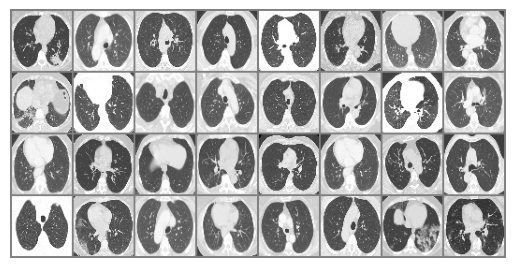

In [22]:
import torchvision

dataiter = iter(train_loader)
images, labels = next(dataiter)

utils.show_img_tensor(torchvision.utils.make_grid(images[:32]))

In [23]:
covid_images = torch.empty((0, 3, 64, 64))
non_covid_images = torch.empty((0, 3, 64, 64))
for image, label in zip(images, labels):
    if label == 0:
        covid_images = torch.cat((covid_images, image.unsqueeze(0)), 0)
    else:
        non_covid_images = torch.cat((non_covid_images, image.unsqueeze(0)), 0)

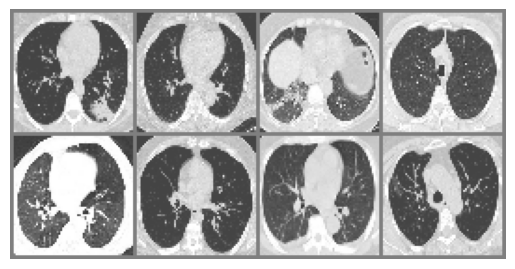

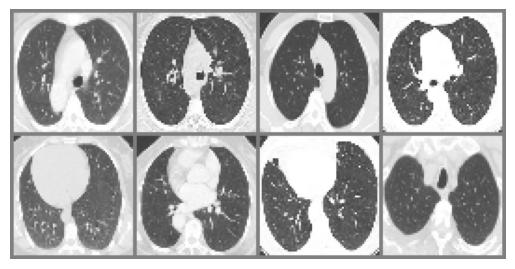

In [24]:
utils.show_img_tensor(torchvision.utils.make_grid(covid_images[:8], nrow=4))
utils.show_img_tensor(torchvision.utils.make_grid(non_covid_images[:8], nrow=4))

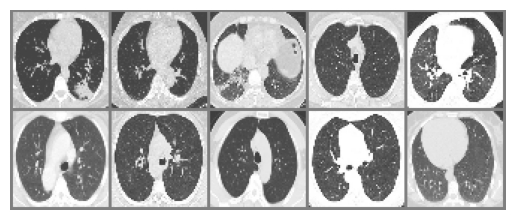

In [35]:
from torchvision.transforms import functional as TF

org_images = torch.cat((covid_images[:5], non_covid_images[:5]), 0) 
img_grid = torchvision.utils.make_grid(org_images, nrow=5)
utils.show_img_tensor(img_grid)

img_path = os.path.join(save_dir, 'sar_org.png')
TF.to_pil_image(img_grid.add(1).div(2).clamp(0, 1)).save(img_path)

In [26]:
# Initialize model.
model = DiffusionModel().to(device)
model_ema = deepcopy(model)
optimizer = optim.Adam(model.parameters(), lr=lr)
grad_scaler = torch.cuda.amp.GradScaler()

In [27]:
# For logging model performance.
metric_keys = ['train_loss']
performance_dict, performance_log = utils.get_performance_loggers(metric_keys)

In [28]:
# Automatic resuming from checkpoint.
log_path = os.path.join(save_dir, 'performance_log.pickle')
if os.path.isfile(log_path):
    performance_log = utils.load_pickle(log_path)
start_epoch = len(performance_log[metric_keys[0]])

ckpt_path = os.path.join(save_dir, 'ckpt_bundle.pth')
if start_epoch > 0:
    ckpt_bundle = torch.load(ckpt_path)
    model.load_state_dict(ckpt_bundle['model'])
    model_ema.load_state_dict(ckpt_bundle['model_ema'])
    optimizer.load_state_dict(ckpt_bundle['optimizer'])
    grad_scaler.load_state_dict(ckpt_bundle['grad_scaler'])

In [29]:
# Train.
for epoch in range(start_epoch, num_epochs):
    utils.print_separator(text='Epoch: {} / {}'.format(epoch + 1, num_epochs))
                    
    # Training.
    model.train()
    for (x, y) in tqdm(train_loader, desc='train'):
        optimizer.zero_grad()
        x = x.to(device)
        y = y.to(device)
        
        # Calculate loss.
        loss = diffusion_loss(model, x, y)
        performance_dict['train_loss'].update_state(loss.item())
        
        # Do the optimizer step and EMA update.
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        ema_update(model, model_ema, 0.95 if epoch < 20 else ema_decay)
        grad_scaler.update()
        
    # Save and print performance.
    for key in metric_keys:
        performance_log[key].append(performance_dict[key].result())
        performance_dict[key].reset_state()
        print(key, ': ',  performance_log[key][-1])
        
    if (epoch + 1) % save_interval == 0:
        torch.save(model.state_dict(), os.path.join(save_dir, 'e_{}.pth'.format(str(epoch + 1).zfill(3))))
        img_path = os.path.join(save_dir, 'demo_{}.png'.format(str(epoch + 1).zfill(3)))
        demo(model, img_path, timesteps, eta)
        clear_output(wait=True)
        
    ckpt_bundle = {
        'model': model.state_dict(),
        'model_ema': model_ema.state_dict(),
        'optimizer': optimizer.state_dict(),
        'grad_scaler': grad_scaler.state_dict(),
    }
    torch.save(ckpt_bundle, ckpt_path)
    utils.save_pickle(log_path, performance_log)

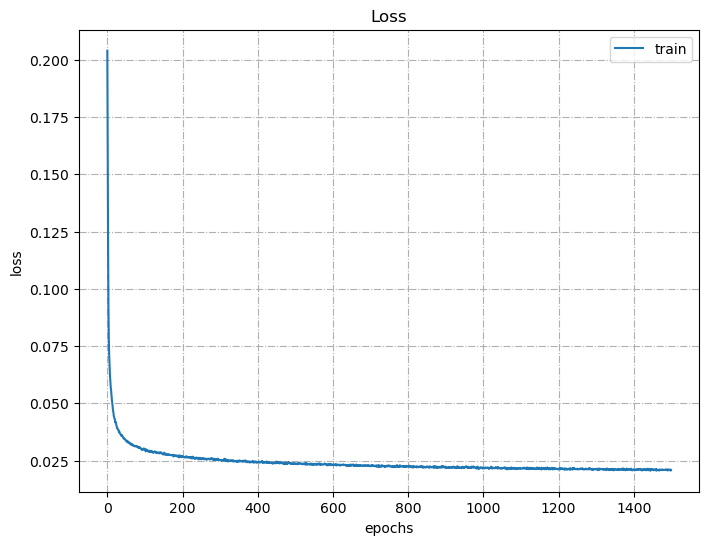

In [30]:
# Plot training history.
performance_log = utils.load_pickle(log_path)

loss_plot_config = utils.LOSS_PLOT_CONFIG.copy()
loss_plot_config['save_dir'] = os.path.join(save_dir, 'loss.png')
loss_plot_config['show_img'] = True
loss_plot_config['xlabel'] = 'epochs'
loss_plot_config['labels'] = ['train']
loss_plot_config['attributes'] = ['train_loss']
utils.save_history_plot(performance_log, loss_plot_config)

In [31]:
# Reload saved model for generation.
# model = DiffusionModel().to(device)
# model.load_state_dict(torch.load(os.path.join(save_dir, 'e_{}.pth'.format('1500'.zfill(3)))))

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 172.63it/s]


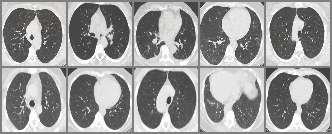

In [39]:
# Generate and save image.
img_path = os.path.join(save_dir, 'demo_final.png')
# demo(model, img_path, timesteps, eta)
demo(model, img_path, timesteps, eta, img_size=img_size, num_images=5, seed=14, num_classes=2)

In [ ]:
# Generate images for evaluation.
# idx_label_dict = {v: k for k, v in train_data.label_idx_dict.items()}
# for idx, label in idx_label_dict.items():
#     num_imgs = train_data.label_count_dict[label]
#     img_class = idx
#     class_dir = os.path.join(save_dir, 'generated_img', label)
#     os.makedirs(class_dir, exist_ok=True)
#     generate_img(model, class_dir, timesteps, eta, num_imgs, img_class, img_size=img_size)

In [ ]:
# from IPython.core.display import HTML
# HTML("<script>Jupyter.notebook.kernel.restart()</script>")